Source data: https://drive.google.com/file/d/1ufiR6hUKhXoAyiBNsySPkUwlvE_wfEHC/view

In [ ]:
# Для подальшої роботи нам знадобиться бібліотека OpenCV. Щоб її встановити, виконайте в терміналі команду pip install opencv-python.

# В подальшій роботі, якщо у вас не встановлена певна бібліотека, її потрібно встановити. Найкращий спосіб знайти правильну бібліотеку — це загуглити назва бібліотеки pypi.
# Індекс пакетів Python (Python Package Index, PyPI) — це сховище програмного забезпечення для мови програмування Python. Тут ви знайдете усі бібліотеки, які можна встановити за допомогою менеджера pip.

# !pip install opencv-python

In [ ]:
import os
import random
from collections import defaultdict
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time

for i in tqdm(range(10)):
  time.sleep(1)

  0%|          | 0/10 [00:00<?, ?it/s]

# Images as matrices

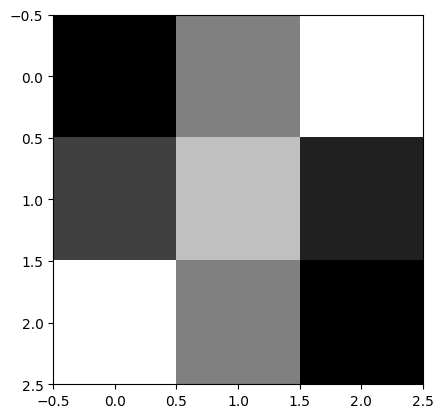

In [ ]:
# Зображення як матриці
# У чорно-білих (або градацій сірого, grayscale) зображеннях кожне значення пікселя представляє відтінок сірого.
# Інтенсивність сірого зазвичай представлена одним числом, яке варіюється від 0 (чорний) до 255 (білий).
data = [[0, 128, 255], [64, 192, 32], [255, 128, 0]]
plt.imshow(data, cmap='gray')
plt.show()

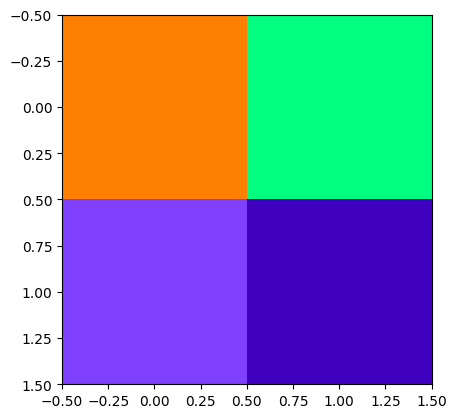

In [ ]:
# Кольорові зображення є більш складними і зазвичай представлені за допомогою колірної моделі RGB.
# У цій моделі кожен піксель описується трьома значеннями, що відповідають червоному (Red), зеленому (Green) та синьому (Blue) кольоровим каналам. Кожне з цих значень зазвичай варіюється від 0 до 255.
data = [[[255, 0], [128, 64]], [[128, 255], [64, 0]], [[0, 128], [255, 192]]]
data = np.moveaxis(data, 0, -1)
plt.imshow(data)
plt.show()

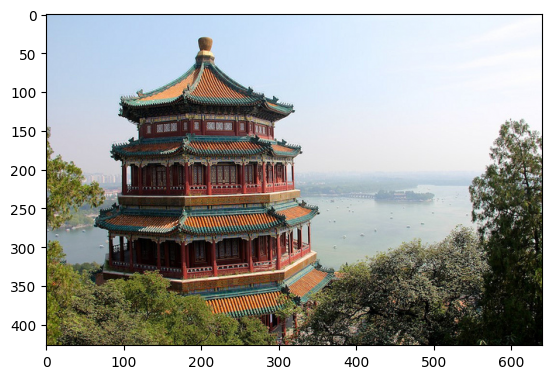

In [ ]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg') / 255
plt.imshow(china)

# EDA

In [ ]:
# задача багатокласової класифікації зображень
# Кожне зображення з цього набору даних — це зображення руки, яка робить знак, який представляє число від 1 до 6.
# Це 1080 навчальних зображень і 120 тестових зображень розміром 64x64.
# Нашою метою буде натренувати модель комп’ютерного зору, яка на вхід буде отримувати зображення знака, а на виході буде передбачати клас від 1 до 6.

# Створимо змінні, в яких буде інформація про теку з даними та назвами підтек.

data_path = '/content/drive/MyDrive/ds/SIGNS dataset/'
# data_path = 'https://raw.githubusercontent.com/alexvekh/DL-course/main/data/SIGNS%dataset/'
splits = ['train', 'test']



В подальшій роботі, якщо у вас не встановлена певна бібліотека, її потрібно встановити. Найкращий спосіб знайти правильну бібліотеку — це загуглити назва бібліотеки pypi.
Індекс пакетів Python (Python Package Index, PyPI) — це сховище програмного забезпечення для мови програмування Python. Тут ви знайдете усі бібліотеки, які можна встановити за допомогою менеджера pip.

1080 images in train
Number of examples for class 0: 180


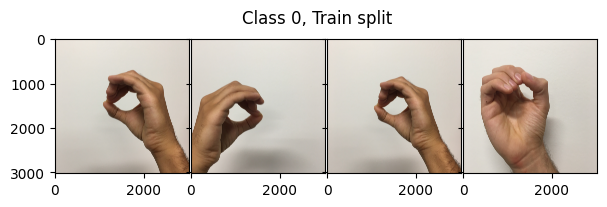

Number of examples for class 1: 180


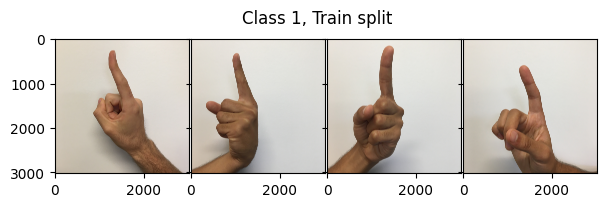

Number of examples for class 2: 180


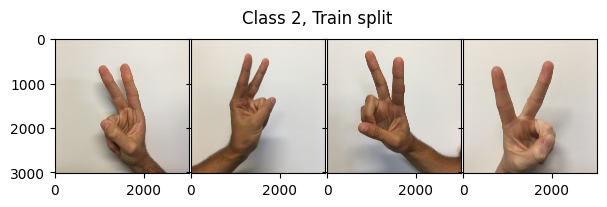

Number of examples for class 3: 180


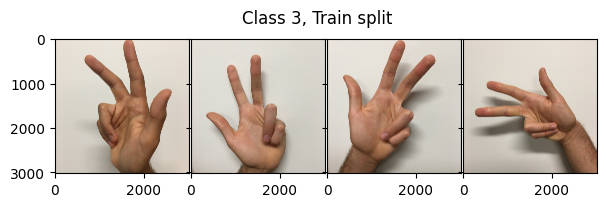

Number of examples for class 4: 180


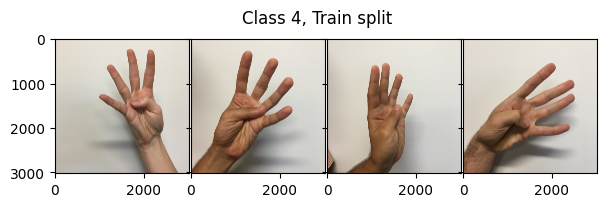

Number of examples for class 5: 180


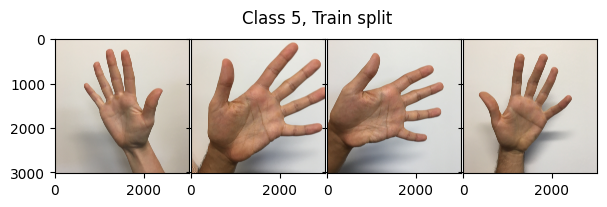

120 images in test
Number of examples for class 0: 20
Number of examples for class 1: 20
Number of examples for class 2: 20
Number of examples for class 3: 20
Number of examples for class 4: 20
Number of examples for class 5: 20


In [ ]:
# Display images examples (Переглянемо приклади зображень, що лежать в теках train та test.)

for s in splits:
    files = [f for f in os.listdir(f"{data_path}{s}_signs") if f.endswith('.jpg')]
    print(f'{len(files)} images in {s}')

    files = [f.split('_', 1) for f in files]

    # group images by sign
    files_by_sign = defaultdict(list)
    for k, v in files:
        files_by_sign[k].append(v)

    # get random 4 images of each sign
    for k, v in sorted(files_by_sign.items()):
        print(f'Number of examples for class {k}:', len(v))

        if s == 'train':
            random.seed(42)

            imgs_path = random.sample(v, 4)
            imgs_path = [os.path.join(data_path, f'{s}_signs/{k}_{p}') for p in imgs_path]

            # read images with opencv
            imgs = [cv2.imread(p) for p in imgs_path]
            # Matplotlib expects img in RGB format but OpenCV provides it in BGR
            imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]

            fig = plt.figure(figsize=(7, 2))
            grid = ImageGrid(
                fig, 111,
                nrows_ncols=(1, 4)
            )
            for ax, img in zip(grid, imgs):
                ax.imshow(img)

            fig.suptitle(f'Class {k}, {s.capitalize()} split')
            plt.show()

In [ ]:
# Image shape, (h, w, dim)
img.shape

(3024, 3024, 3)

# Convolution layer

In [ ]:
input = torch.randn(20, 16, 50, 100) # batch_size, in_channels, h, w

Згортковий шар в PyTorch реалізується функцією nn.Conv2d()

параметри:

- in_channels (int) – кількість каналів у вхідному зображенні;
- out_channels (int) – кількість каналів, створених згорткою;
- kernel_size (int або tuple) – розмір згорнутого ядра;
- stride (int або tuple, необов’язково) – крок згортки (за замовчуванням - 1);
- padding (int, tuple або str, необов’язково) – padding додається до всіх чотирьох сторін введення, типове значення - 0;
- dilation (розширення) (int або tuple, необов’язково) – інтервал між елементами ядра (за замовчуванням - 1).

Для вхідних даних розміру (N, Cin, H, W) ми отримаємо вихід розміром
(N, Cout, Hout, Wout), де:
- N - розмір батчу,
- C - кількість каналів зображення,
- H – висота вхідного зображення у пікселях,
- W— ширина в пікселях.

In [ ]:
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 3, stride=2)
output = m(input)
output.shape

torch.Size([20, 33, 24, 49])

In [ ]:
# non-square kernels and unequal stride and with padding
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
output = m(input)
output.shape

torch.Size([20, 33, 28, 100])

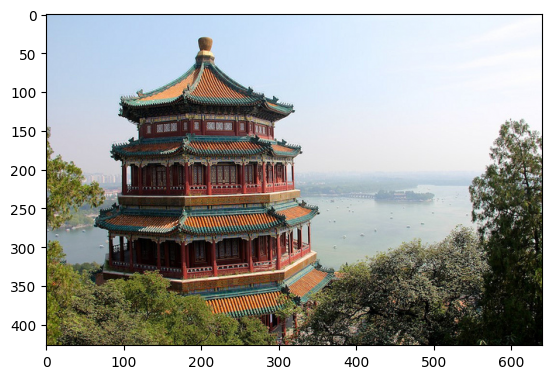

In [ ]:
plt.imshow(china)

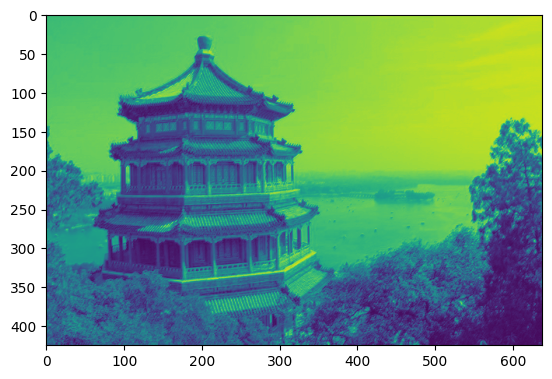

In [ ]:
out = nn.Conv2d(3, 1, 3)(torch.tensor(np.array([np.moveaxis(china, 2, 0)]), dtype=torch.float32))
plt.imshow(out.detach().numpy()[0][0])

In [ ]:
[1,2,1]     102314
[0,3,4]  ->

# Pooling layer

In [ ]:
input = torch.randn(20, 16, 50, 100) # batch_size, in_channels, h, w

In [ ]:
# pool of square window of kernel_size=2, stride=2
m = nn.MaxPool2d(2)
output = m(input)
output.shape

torch.Size([20, 16, 25, 50])

In [ ]:
# pool of non-square window
m = nn.MaxPool2d((3, 2), stride=(2, 1))
output = m(input)
output.shape

torch.Size([20, 16, 24, 99])

Classification layers

# Augmentations

**Data Augmentation** is a technique used to artificially increase dataset size. Take a sample from the dataset, modify it somehow, add it to the original dataset — and now your dataset is one sample larger.

In [ ]:
from PIL import Image

import torchvision.transforms as T

In [ ]:
orig_img = Image.fromarray(img)

In [ ]:
def plot_examples(transformed_imgs:list, col_titles:list, cmap=None):

    n_cols = len(transformed_imgs) +1
    fig_size_x = 3 + len(transformed_imgs) * 1.5
    fig, axs = plt.subplots(1, n_cols, figsize=(fig_size_x,2))

    axs[0].imshow(orig_img)
    axs[0].set_title('original image')

    for i in range(len(transformed_imgs)):
        axs[i+1].imshow(transformed_imgs[i], cmap=cmap)
        axs[i+1].set_title(col_titles[i])

    plt.tight_layout()
    plt.show()

**Resize**

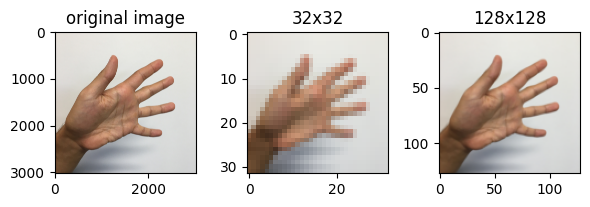

In [ ]:
resized_imgs = [T.Resize(size=size)(orig_img) for size in [32,128]]

plot_examples(resized_imgs, ['32x32', '128x128'])

**Gray Scale**

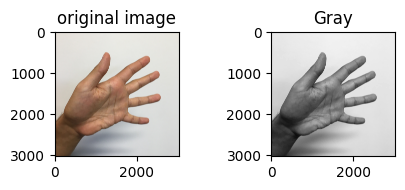

In [ ]:
gray_img = T.Grayscale()(orig_img)

plot_examples([gray_img], ["Gray"], 'gray')

**Normalize**<br>
The normalization can constitute an effective way to speed up the computations in the model based on neural network architecture and learn faster. There are two steps to normalize the images:

* we subtract the channel mean from each input channel
* later, we divide it by the channel standard deviation.


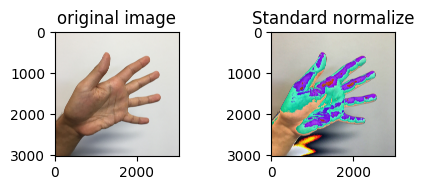

In [ ]:
normalized_img = T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(T.ToTensor()(orig_img))
normalized_img = [T.ToPILImage()(normalized_img)]

plot_examples(normalized_img, ["Standard normalize"])

**Random Rotation**

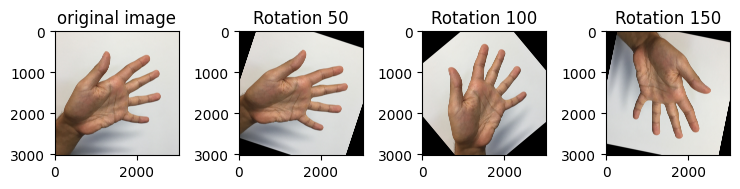

In [ ]:
rotated_imgs = [T.RandomRotation(degrees=d)(orig_img) for d in range(50,151,50)]
plot_examples(rotated_imgs, ["Rotation 50","Rotation 100","Rotation 150"])

**Center Crop**

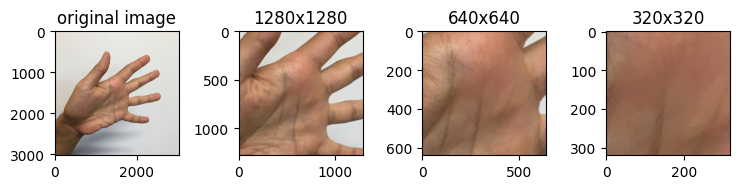

In [ ]:
center_crops = [T.CenterCrop(size=size)(orig_img) for size in (1280,640, 320)]
plot_examples(center_crops,['1280x1280','640x640','320x320'])

**Random Crop**

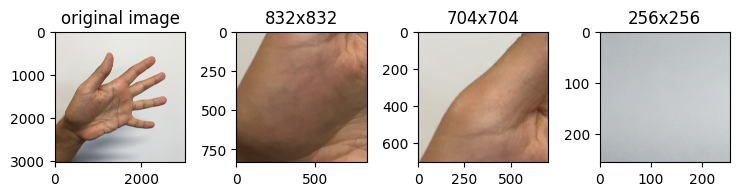

In [ ]:
random_crops = [T.RandomCrop(size=size)(orig_img) for size in (832,704, 256)]
plot_examples(random_crops,['832x832','704x704','256x256'])

**Gaussian Blur**<br>

We apply a Gaussian blur transform to the image using a Gaussian kernel. This method can be helpful in making the image less clear and distinct and, then, this resulting image is fed into a neural network, which becomes more robust in learning patterns of the samples.

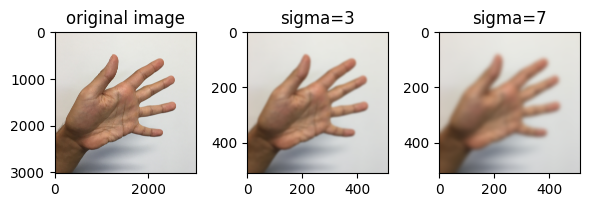

In [ ]:
downsized_img = T.Resize(size=512)(orig_img)
blurred_imgs = [T.GaussianBlur(kernel_size=(51, 91), sigma=sigma)(downsized_img) for sigma in (3,7)]
plot_examples(blurred_imgs, ['sigma=3', 'sigma=7'])

**Gaussian Noise** <br>
The Gaussian Noise is a popular way to add noise to the whole dataset, forcing the model to learn the most important information contained in the data. It consists in injecting a Gaussian Noise matrix, which is a matrix of random values drawn from a Gaussian distribution. Later, we clip the samples between 0 and 1. The more the noise factor is higher, the more noisy the image is.

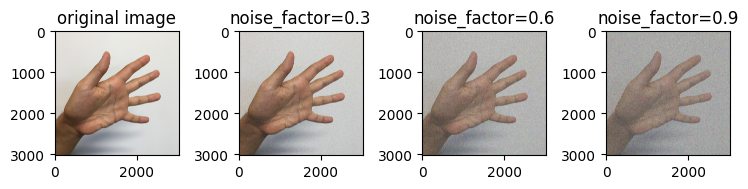

In [ ]:
def add_noise(inputs,noise_factor=0.3):
    noisy = inputs+torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

noise_imgs = [add_noise(T.ToTensor()(orig_img),noise_factor) for noise_factor in (0.3,0.6,0.9)]
noise_imgs = [T.ToPILImage()(noise_img) for noise_img in noise_imgs]
plot_examples(noise_imgs, ["noise_factor=0.3","noise_factor=0.6","noise_factor=0.9"])

Usefull library: https://github.com/albumentations-team/albumentations

## Baseline

In [ ]:
class SIGNSDataset(Dataset):
    def __init__(self, data_dir, transform):
        #store filenames
        self.filenames = os.listdir(data_dir)
        self.filenames = [os.path.join(data_dir, f) for f in self.filenames if f.endswith('.jpg')]
        #the first character of the filename contains the label
        self.labels = [int(filename.split('/')[-1][0]) for filename in self.filenames]
        self.transform = transform

    def __len__(self):
        #return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        #open image, apply transforms and return with label
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
train_transformer = T.Compose([
    T.Resize(64),              # resize the image to 64x64
    T.RandomHorizontalFlip(),  # randomly flip image horizontally
    T.ToTensor()])             # transform it into a PyTorch Tensor

test_transformer = T.Compose([
    T.Resize(64),
    T.ToTensor()])

In [ ]:
train_dataset = SIGNSDataset(f'{data_path}train_signs/', train_transformer)
test_dataset = SIGNSDataset(f'{data_path}test_signs/', test_transformer)

In [ ]:
class BaselineModel(nn.Module):

    def __init__(self, ):
        super().__init__()
        self.num_channels = 32

        # each of the convolution layers below have the arguments (input_channels, output_channels, filter_size,
        # stride, padding). We also include batch normalisation layers that help stabilise training.

        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

        # 2 fully connected layers to transform the output of the convolution layers to the final output
        self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)

    def forward(self, s):
        #                                                  -> batch_size x 3 x 64 x 64
        # we apply the convolution layers, followed by batch normalisation, maxpool and relu x 3
        s = self.conv1(s)                                   # batch_size x num_channels x 64 x 64
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels x 32 x 32
        s = self.conv2(s)                                   # batch_size x num_channels*2 x 32 x 32
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*2 x 16 x 16
        s = self.conv3(s)                                   # batch_size x num_channels*4 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*4 x 8 x 8

        # flatten the output for each image
        s = s.view(-1, 8*8*self.num_channels*4)             # batch_size x 8*8*num_channels*4

        # apply 2 fully connected layers with dropout
        s = F.relu(self.fc1(s))                             # batch_size x self.num_channels*4
        s = self.fc2(s)                                     # batch_size x 6

        # apply log softmax on each image's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)


In [ ]:
cuda = torch.cuda.is_available()

# Set the random seed for reproducible experiments
torch.manual_seed(42)
if cuda:
    torch.cuda.manual_seed(42)

# Specify a computing device
device = 'cuda' if cuda else None
cuda

False

In [ ]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              shuffle=True,
                              num_workers=2)

test_dataloader = DataLoader(test_dataset,
                             batch_size=20,
                             shuffle=False,
                             num_workers=1)

In [ ]:
# Define the model and optimizer
model = BaselineModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
os.environ['WANDB_CONSOLE'] = 'off'

# Define loss function
criterion = nn.CrossEntropyLoss().to(device)

# Train the model

train_losses = []
train_accs = []

test_losses = []
test_accs = []

num_epochs = 15

for epoch in tqdm(range(num_epochs)):

    # Train step

    model.train()

    train_epoch_loss = []
    train_epoch_acc = []

    for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader)):
        if cuda:
            train_batch, labels_batch = train_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

        # compute model output and loss
        output_batch = model(train_batch)

        loss = criterion(output_batch, labels_batch)

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()

        batch_loss = loss.cpu().detach().numpy()
        batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                            labels_batch.cpu().detach().numpy())

        train_epoch_loss.append(batch_loss)
        train_epoch_acc.append(batch_acc)

        if i >=4:
              break


    print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
    train_accs.append(np.mean(train_epoch_acc))
    train_losses.append(np.mean(train_epoch_loss))

    # Eval step

    model.eval()

    test_epoch_loss = []
    test_epoch_acc = []

    with torch.no_grad():

        for i, (test_batch, labels_batch) in enumerate(test_dataloader):
            if cuda:
                test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

            # compute model output and loss
            output_batch = model(test_batch)

            loss = criterion(output_batch, labels_batch)

            batch_loss = loss.cpu().detach().numpy()
            batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                                labels_batch.cpu().detach().numpy())

            test_epoch_loss.append(batch_loss)
            test_epoch_acc.append(batch_acc)

    print(f'Test epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')
    test_accs.append(np.mean(test_epoch_acc))
    test_losses.append(np.mean(test_epoch_loss))

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train epoch [1/15], Loss: 1.8210, Acc: 0.17
Test epoch [1/15], Loss: 1.7962, Acc: 0.16666666666666666


0it [00:00, ?it/s]

Train epoch [2/15], Loss: 1.7979, Acc: 0.23222222222222225
Test epoch [2/15], Loss: 1.7917, Acc: 0.16982570806100217


0it [00:00, ?it/s]

Train epoch [3/15], Loss: 1.7905, Acc: 0.19333333333333333
Test epoch [3/15], Loss: 1.7911, Acc: 0.16666666666666666


0it [00:00, ?it/s]

Train epoch [4/15], Loss: 1.7924, Acc: 0.16
Test epoch [4/15], Loss: 1.7894, Acc: 0.16666666666666666


0it [00:00, ?it/s]

Train epoch [5/15], Loss: 1.7819, Acc: 0.18
Test epoch [5/15], Loss: 1.7832, Acc: 0.16587833963994955


0it [00:00, ?it/s]

Train epoch [6/15], Loss: 1.7741, Acc: 0.32018503555268263
Test epoch [6/15], Loss: 1.7743, Acc: 0.2977124183006536


0it [00:00, ?it/s]

Train epoch [7/15], Loss: 1.7143, Acc: 0.4453185703185703
Test epoch [7/15], Loss: 1.7466, Acc: 0.189429012345679


0it [00:00, ?it/s]

Train epoch [8/15], Loss: 1.6522, Acc: 0.36108447108447106


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test epoch [8/15], Loss: 1.6618, Acc: 0.20204495939790057


0it [00:00, ?it/s]

Train epoch [9/15], Loss: 1.4503, Acc: 0.5451190476190476


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test epoch [9/15], Loss: 1.6430, Acc: 0.21660714285714286


0it [00:00, ?it/s]

Train epoch [10/15], Loss: 1.3886, Acc: 0.566334656084656


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test epoch [10/15], Loss: 1.7040, Acc: 0.2606944444444444


0it [00:00, ?it/s]

Train epoch [11/15], Loss: 1.1166, Acc: 0.6432460317460318


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test epoch [11/15], Loss: 1.7659, Acc: 0.2576465201465202


0it [00:00, ?it/s]

Train epoch [12/15], Loss: 1.1618, Acc: 0.5509523809523809


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test epoch [12/15], Loss: 1.9028, Acc: 0.2716951566951567


Exception ignored in: 

0it [00:00, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataload

Train epoch [13/15], Loss: 0.9920, Acc: 0.6691089466089466


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test epoch [13/15], Loss: 1.9737, Acc: 0.31182012432012435


0it [00:00, ?it/s]

Train epoch [14/15], Loss: 1.0297, Acc: 0.6042857142857143
Test epoch [14/15], Loss: 1.7632, Acc: 0.2292857142857143


0it [00:00, ?it/s]

Train epoch [15/15], Loss: 1.0839, Acc: 0.6534920634920635


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9017cd9e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test epoch [15/15], Loss: 1.8129, Acc: 0.31702845765345766


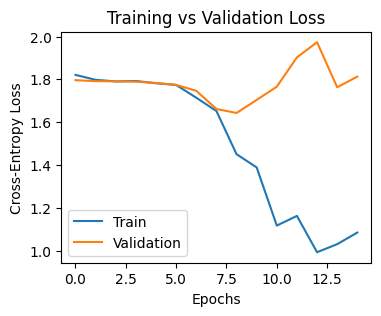

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs Validation Loss')
plt.show()

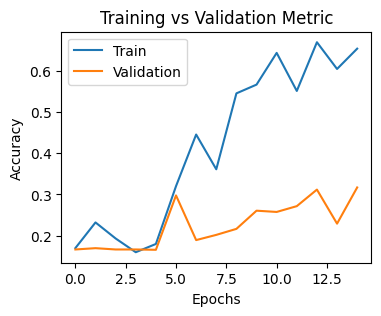

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Metric')
plt.show()